In [3]:
! pip install scikit-learn

     ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
     - -------------------------------------- 0.5/9.3 MB 9.4 MB/s eta 0:00:01
     --- ------------------------------------ 0.7/9.3 MB 9.3 MB/s eta 0:00:01
     ---- ----------------------------------- 1.1/9.3 MB 7.5 MB/s eta 0:00:02
     ------ --------------------------------- 1.5/9.3 MB 6.8 MB/s eta 0:00:02
     -------- ------------------------------- 1.9/9.3 MB 7.2 MB/s eta 0:00:02
     --------- ------------------------------ 2.2/9.3 MB 7.0 MB/s eta 0:00:02
     ---------- ----------------------------- 2.4/9.3 MB 6.4 MB/s eta 0:00:02
     ---------- ----------------------------- 2.5/9.3 MB 6.0 MB/s eta 0:00:02
     ----------- ---------------------------- 2.6/9.3 MB 5.6 MB/s eta 0:00:02
     ----------- ---------------------------- 2.8/9.3 MB 5.3 MB/s eta 0:00:02
     ------------ --------------------------- 2.9/9.3 MB 5.2 MB/s eta 0:00:02
     ------------ --------------------------- 3.0/9.3 MB 5.1 MB/s eta 0


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [108]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.metrics import accuracy_score
import numpy as np

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [121]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)


1. visualize data
2. convert data to tensor(float32), train-test split
3. build model
4. loss function
5. optimizer
6. Training and testing loop

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

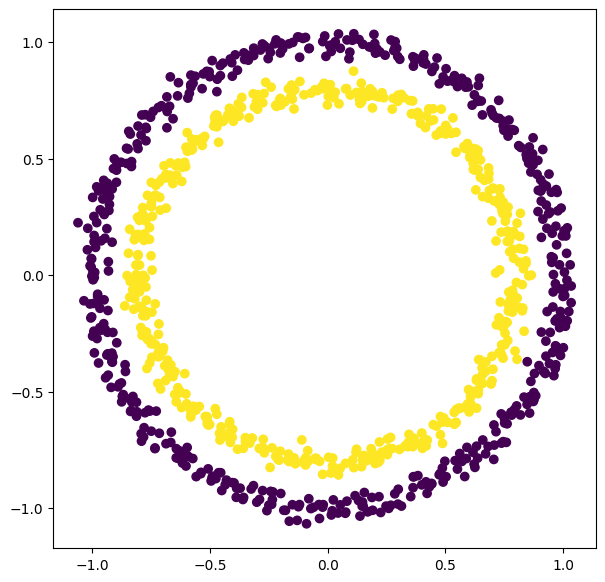

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=y)

In [122]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.to(device)
X_test.to(device)
y_test.to(device)
y_train.to(device)

tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 

In [123]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 8)
        self.layer2 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.relu(x1)
        x3 = self.layer2(x2)
        return x3

model = CircleModel().to(device)




##### Tried using tanh and sigmoid on playground.tensorflow.org, derivative of sigmoid is very small compared to tanh so weight updates are slow. increasing learning rate helps sigmoid. 
BCEwithlogitsloss means first sigmoid then binary cross etropy loss, used for better numerical stability.

In [124]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)
model.state_dict().items()

odict_items([('layer1.weight', tensor([[-0.2338, -0.0828],
        [ 0.2226,  0.3041],
        [ 0.4602,  0.0240],
        [-0.2909,  0.1642],
        [ 0.3806, -0.4057],
        [ 0.0703,  0.1920],
        [ 0.7020, -0.6887],
        [-0.1852,  0.5870]])), ('layer1.bias', tensor([-0.5132,  0.1490,  0.3283,  0.3106,  0.5162, -0.4479, -0.4401,  0.6807])), ('layer2.weight', tensor([[-0.0516, -0.3332, -0.2892,  0.0790,  0.0933,  0.1350, -0.1488, -0.2172]])), ('layer2.bias', tensor([-0.1789]))])

### Training loop

In [125]:
num_epochs = 2000

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
for epochs in range(num_epochs):
    # model.train()
    logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(logits))
    loss = loss_fn(logits, y_train)
    accuracy = accuracy_score(y_train, y_pred.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_score(y_test, y_pred_test.detach().numpy())
        train_accuracy_values.append(accuracy)
        test_accuracy_values.append(test_accuracy)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        if(epochs % 100 == 0):
            print(f"Epoch {epochs}: Train loss {loss}, Train accuracy {accuracy}, Test loss {test_loss}, Test accuracy {test_accuracy}")

Epoch 0: Train loss 0.7156113982200623, Train accuracy 0.5, Test loss 0.704018235206604, Test accuracy 0.5
Epoch 100: Train loss 0.6819660663604736, Train accuracy 0.55, Test loss 0.6815504431724548, Test accuracy 0.555
Epoch 200: Train loss 0.66990065574646, Train accuracy 0.64625, Test loss 0.6715290546417236, Test accuracy 0.66
Epoch 300: Train loss 0.6492259502410889, Train accuracy 0.6925, Test loss 0.655124306678772, Test accuracy 0.665
Epoch 400: Train loss 0.6153221726417542, Train accuracy 0.795, Test loss 0.6289449334144592, Test accuracy 0.735
Epoch 500: Train loss 0.5609937906265259, Train accuracy 0.865, Test loss 0.5865919589996338, Test accuracy 0.81
Epoch 600: Train loss 0.48570477962493896, Train accuracy 0.91, Test loss 0.5227800607681274, Test accuracy 0.845
Epoch 700: Train loss 0.3958693742752075, Train accuracy 0.95, Test loss 0.44297707080841064, Test accuracy 0.925
Epoch 800: Train loss 0.3095041513442993, Train accuracy 0.97875, Test loss 0.36907118558883667, T

In [126]:
def plot_decision_boundary(X, y, model, title="Decision Boundary", xlabel="Feature 1", ylabel="Feature 2"):
    model.eval()
    h = 0.02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    meshgrid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(meshgrid_tensor)
        Z = torch.sigmoid(Z).numpy().reshape(xx.shape) 

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k', marker='o')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


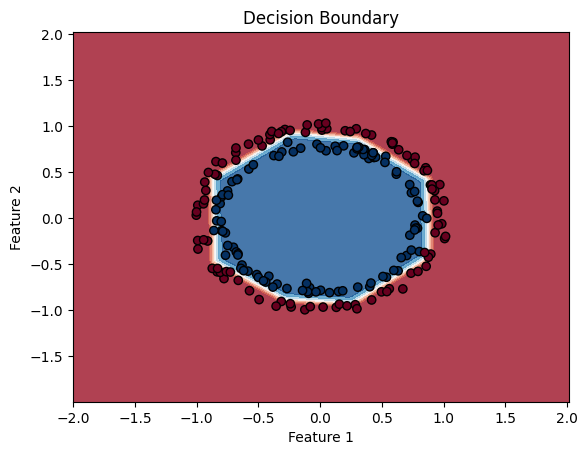

In [127]:
plot_decision_boundary(X_test,y_test, model)

In [185]:
import numpy as np 
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.metrics import accuracy_score

In [146]:
def spiral(radius, step, resolution=.1, angle=0.0, start=0.0):
    dist = start+0.0
    coords=[]
    while dist*math.hypot(math.cos(angle),math.sin(angle))<radius:
        cord=[]
        cord.append(dist*math.cos(angle))
        cord.append(dist*math.sin(angle))
        coords.append(cord)
        dist+=step
        angle+=resolution
    return np.array(coords)

In [163]:
X1 = spiral(10, 0.1)
X2 = spiral(10, 0.1, angle=math.pi)
X1 = np.insert(X1, X1.shape[1], 1, axis=1)
X2 = np.insert(X2, X2.shape[1], 0, axis=1)

X1.shape, X2.shape

((101, 3), (101, 3))

In [164]:
X2[:5]

array([[-0.        ,  0.        ,  0.        ],
       [-0.09950042, -0.00998334,  0.        ],
       [-0.19601332, -0.03973387,  0.        ],
       [-0.28660095, -0.08865606,  0.        ],
       [-0.3684244 , -0.15576734,  0.        ]])

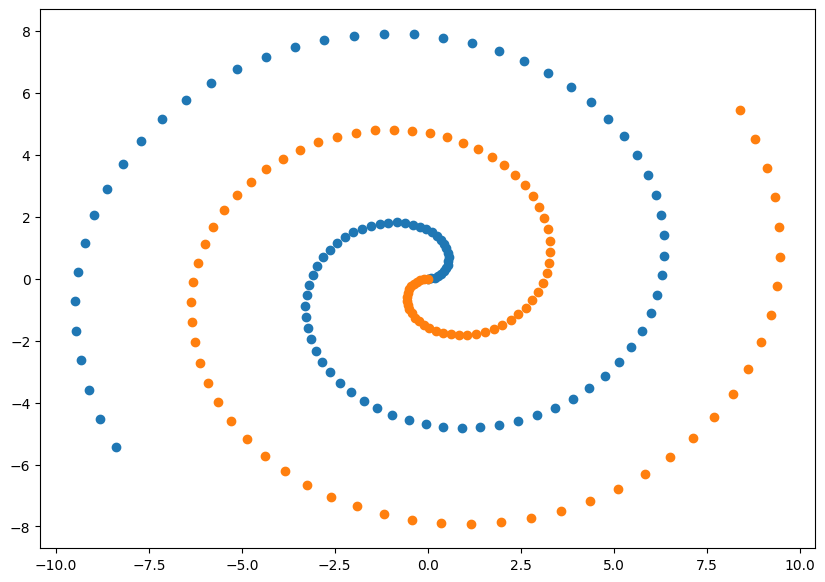

In [148]:
plt.figure(figsize=(10,7))
plt.scatter(X1[:, 0], X1[:,1])
plt.scatter(X2[:, 0], X2[:,1])
plt.show()

In [165]:
data = np.vstack([X1, X2])
data.shape

(202, 3)

In [177]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

1. Visualize data
2. Convert to tensor(float32), send to device
3. train test split
4. Build model
5. loss function and optimizer
6. Training loop and testing loop

In [174]:
data = torch.from_numpy(data).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(data[:, :2], data[:, 2:3], test_size=0.2, random_state=42, shuffle=True)
 

In [178]:
X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

(tensor([[ 9.1182,  3.5915],
         [-3.0057, -2.3251],
         [-1.7697,  1.6211],
         [ 1.0602, -1.8127],
         [ 9.4530,  1.6735],
         [-2.8158,  0.6938],
         [-0.6143,  1.7980],
         [ 1.7234,  3.9395],
         [-5.8370,  6.3158],
         [-0.3477, -1.2526],
         [-3.2453, -6.6504],
         [ 0.4388,  0.2397],
         [ 2.2279, -1.3403],
         [ 0.0467, -1.5993],
         [ 3.8404,  6.2082],
         [ 2.6146,  3.0272],
         [-9.1182, -3.5915],
         [-3.8404, -6.2082],
         [-9.4530, -1.6735],
         [-5.2773, -4.5989],
         [-9.3349, -2.6361],
         [-3.0973,  0.1289],
         [ 0.4348,  1.1184],
         [-3.2776, -1.2277],
         [ 0.4090, -1.7529],
         [-2.0591, -3.6606],
         [ 8.2002, -3.7091],
         [-8.2002,  3.7091],
         [ 3.2283,  1.5931],
         [ 1.9277, -4.7217],
         [ 2.4410, -1.1539],
         [-6.1786,  0.5152],
         [-2.3568, -3.3549],
         [ 0.2190, -1.6858],
         [-0.4

In [180]:
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(2, 8)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.relu(x1)
        x3 = self.layer2(x2)
        x4 = self.relu(x3)
        x5 = self.layer3(x4)

        return x5

model = SpiralModel()



In [182]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [190]:
y_train.shape

torch.Size([161, 1])

### Training loop

In [186]:
num_epochs = 1000
test_accuracy_values = []
train_accuracy_values = []

for epochs in range(num_epochs + 1):
    model.train()

    y_pred = model(X_train)
    train_loss = loss_fn(y_pred, y_train)
    train_accuracy = accuracy_score(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        test_y_pred = model(X_test)
        test_loss = loss_fn(test_y_pred, y_test)
        test_accuracy = accuracy_score(y_test, test_y_pred)
        test_accuracy_values.append(test_accuracy)
        train_accuracy_values.append(train_accuracy)
        if(epochs % 100 == 0):
            print(f"Epoch {epochs} : Train accuracy {train_accuracy} | Test accuracy {test_accuracy}")

ValueError: Using a target size (torch.Size([161, 1])) that is different to the input size (torch.Size([161, 2])) is deprecated. Please ensure they have the same size.